In [ ]:
!gdown --id 1tf3y7AsGztdlYR07QJM_2bQXm9OTqkCg

In [ ]:
!gdown --id 1CDj-IwNtgXsnDHoKUgc5msEX1xgBYz65

In [ ]:
!unzip -o sunday-non-meditator.zip

In [ ]:
!unzip -o sunday-meditator.zip

In [ ]:
!pip install -U mne

In [ ]:
pip install mne

In [20]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import f_oneway, ttest_ind

In [8]:
meditator_data_path = '/content/sunday-meditator'
non_meditator_data_path = '/content/sunday-non-meditator'

In [16]:
# Define frequency bands
frequency_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 14), 'Beta': (14, 30), 'Gamma': (30, 40)}

# Time segments (every 10 minutes within an hour)
time_segments = [(0, 600), (600, 1200), (1200, 1800), (1800, 2400), (2400, 3000), (3000, 3600)]

# Calculate PSD and Extract Band Powers

In [17]:
def calculate_segment_band_powers(file_path, time_segments, frequency_bands):
    # Load the data
    raw = mne.io.read_raw_fif(file_path, preload=True)

    # Trim to 3600 seconds if longer
    if raw.times[-1] / raw.info['sfreq'] > 3600:
        raw.crop(tmin=0, tmax=3600)

    segment_band_powers = {segment: {band: [] for band in frequency_bands} for segment in range(len(time_segments))}

    # Calculate PSD for each segment
    for i, (start, end) in enumerate(time_segments):
        segment_data = raw.copy().crop(tmin=start, tmax=end).get_data()
        sfreq = raw.info['sfreq']
        psd, freqs = mne.time_frequency.psd_array_welch(segment_data, sfreq=sfreq, fmin=0.5, fmax=40, n_fft=2048, average='mean', n_overlap=1024, verbose=False)

        for band, (fmin, fmax) in frequency_bands.items():
            idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
            band_power = np.mean(psd[:, idx_band], axis=1).mean()
            segment_band_powers[i][band] = band_power

    return segment_band_powers


In [ ]:
def process_group(data_path, time_segments, frequency_bands):
    group_band_powers = []

    for file_name in sorted(os.listdir(data_path)):
        if file_name.endswith('.fif'):
            file_path = os.path.join(data_path, file_name)
            segment_band_powers = calculate_segment_band_powers(file_path, time_segments, frequency_bands)
            group_band_powers.append(segment_band_powers)

    return group_band_powers


In [ ]:
# Process each group
meditator_band_powers = process_group(meditator_data_path, time_segments, frequency_bands)
non_meditator_band_powers = process_group(non_meditator_data_path, time_segments, frequency_bands)



# Process EEG Data for Both Groups

# Statistical Analysis

In [23]:
# Initialize a dictionary to store results
results = {segment: {band: None for band in frequency_bands} for segment in range(1, len(time_segments) + 1)}

for segment in range(len(time_segments)):
    for band in frequency_bands:
        # Extract band powers for the current segment and band
        med_powers = [med[segment][band] for med in meditator_band_powers]
        non_med_powers = [non_med[segment][band] for non_med in non_meditator_band_powers]

        # Perform t-test
        t_stat, p_val = ttest_ind(med_powers, non_med_powers)
        results[segment + 1][band] = (t_stat, p_val)

# Print summary of results with significance indication
for segment, bands in results.items():
    print(f"\nSegment {segment} Results:")
    for band, stats in bands.items():
        # Determine significance based on p-value
        significance = "Significant" if stats[1] < 0.05 else "Not Significant"

        print(f"{band} band: t={stats[0]:.2f}, p={stats[1]:.4f} ({significance})")



Segment 1 Results:
Delta band: t=3.04, p=0.0070 (Significant)
Theta band: t=0.16, p=0.8760 (Not Significant)
Alpha band: t=-0.46, p=0.6524 (Not Significant)
Beta band: t=-0.54, p=0.5930 (Not Significant)
Gamma band: t=-0.68, p=0.5032 (Not Significant)

Segment 2 Results:
Delta band: t=1.40, p=0.1782 (Not Significant)
Theta band: t=0.71, p=0.4894 (Not Significant)
Alpha band: t=1.06, p=0.3021 (Not Significant)
Beta band: t=1.07, p=0.2998 (Not Significant)
Gamma band: t=0.93, p=0.3668 (Not Significant)

Segment 3 Results:
Delta band: t=1.00, p=0.3294 (Not Significant)
Theta band: t=0.89, p=0.3832 (Not Significant)
Alpha band: t=1.04, p=0.3138 (Not Significant)
Beta band: t=0.94, p=0.3575 (Not Significant)
Gamma band: t=0.92, p=0.3702 (Not Significant)

Segment 4 Results:
Delta band: t=1.21, p=0.2402 (Not Significant)
Theta band: t=0.22, p=0.8257 (Not Significant)
Alpha band: t=1.12, p=0.2769 (Not Significant)
Beta band: t=1.03, p=0.3151 (Not Significant)
Gamma band: t=0.99, p=0.3369 (No

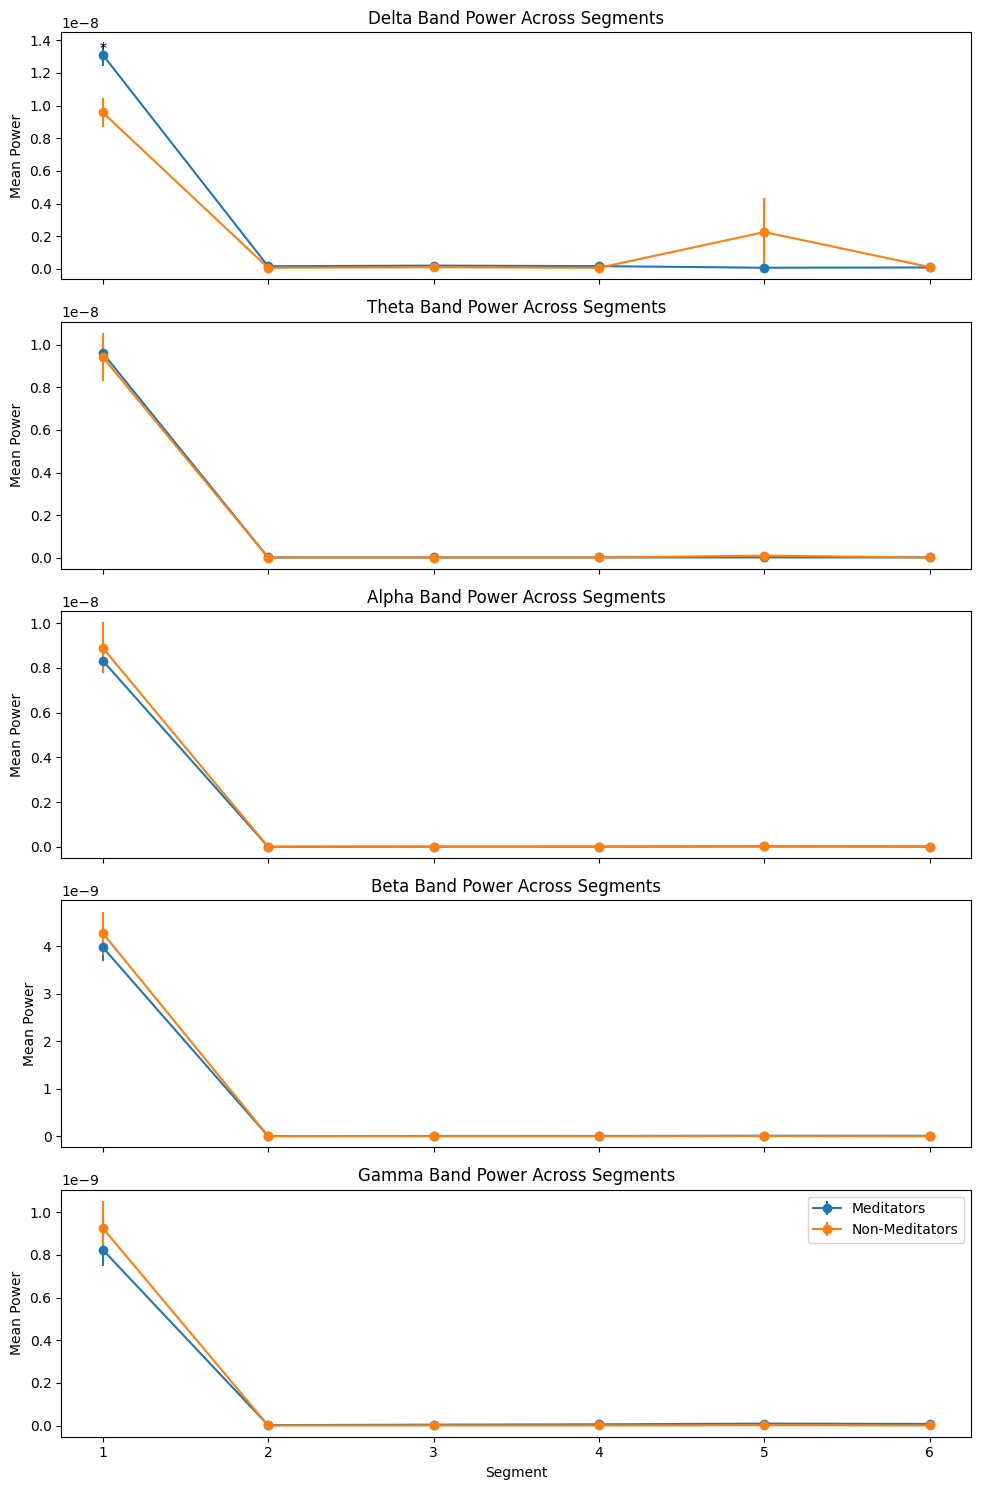

In [22]:
import matplotlib.pyplot as plt

# Set up the figure layout
fig, axs = plt.subplots(len(frequency_bands), 1, figsize=(10, 15), sharex=True)
if len(frequency_bands) == 1:  # Ensure axs is iterable
    axs = [axs]

# Plot data
for i, (band, ax) in enumerate(zip(frequency_bands, axs)):
    med_means = [np.mean([med[segment][band] for med in meditator_band_powers]) for segment in range(len(time_segments))]
    non_med_means = [np.mean([non_med[segment][band] for non_med in non_meditator_band_powers]) for segment in range(len(time_segments))]

    # Error bars (standard error of the mean)
    med_sems = [np.std([med[segment][band] for med in meditator_band_powers]) / np.sqrt(len(meditator_band_powers)) for segment in range(len(time_segments))]
    non_med_sems = [np.std([non_med[segment][band] for non_med in non_meditator_band_powers]) / np.sqrt(len(non_meditator_band_powers)) for segment in range(len(time_segments))]

    segments = range(1, len(time_segments) + 1)
    ax.errorbar(segments, med_means, yerr=med_sems, label='Meditators', fmt='-o')
    ax.errorbar(segments, non_med_means, yerr=non_med_sems, label='Non-Meditators', fmt='-o')

    ax.set_title(f'{band} Band Power Across Segments')
    ax.set_ylabel('Mean Power')
    for seg in segments:
        p_val = results[seg][band][1]
        significance = "*" if p_val < 0.05 else ""
        ax.text(seg, max(max(med_means), max(non_med_means)), significance, ha='center', va='bottom')

axs[-1].set_xlabel('Segment')
plt.legend()
plt.tight_layout()
plt.show()